In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M83 star cluster catalog of Chandar et
# al. (2010, ApJ, 719, 966)

# Import the libraries we'll need
from astropy.io import ascii
import numpy as np
import numpy.ma as ma
import time
import matplotlib.pyplot as plt
from slugpy.cluster_slug import cluster_slug

# Read the Chandar et al photometric catalog
print("Reading Chandar et al. (2010) data...")
chdata \
    = ascii.read('hlsp_wfc3ers_hst_wfc3_m83_cat_cluster_auto_v1.txt')

# Read Chandar et al best fits of mass and age
chfits = ascii.read('hlsp_m83_autocat_ages_public.data')

# Distance modulus to M83
dmod = 28.29

Reading Chandar et al. (2010) data...


In [2]:
# Extract photometry from the Chandar catalog and pack it into arrays
cluster_id = np.array(chdata['col5'])
chdata['col18'][chdata['col18'] == 'INDEF'] = -99
m336 = ma.masked_equal(np.array(chdata['col18'], 
                                dtype='float64'), -99) - dmod
chdata['col19'][chdata['col19'] == 'INDEF'] = -99
m336err = ma.masked_equal(np.array(chdata['col19'], 
                                   dtype='float64'), -99)
chdata['col26'][chdata['col26'] == 'INDEF'] = -99
m438 = ma.masked_equal(np.array(chdata['col26'], 
                                dtype='float64'), -99) - dmod
chdata['col27'][chdata['col27'] == 'INDEF'] = -99
m438err = ma.masked_equal(np.array(chdata['col27'],
                                   dtype='float64'), -99)
chdata['col38'][chdata['col38'] == 'INDEF'] = -99
m555 = ma.masked_equal(np.array(chdata['col38'],
                                dtype='float64'), -99) - dmod
chdata['col39'][chdata['col39'] == 'INDEF'] = -99
m555err = ma.masked_equal(np.array(chdata['col39'],
                                   dtype='float64'), -99)
chdata['col50'][chdata['col50'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(chdata['col50'],
                                dtype='float64'), -99) - dmod
chdata['col51'][chdata['col51'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(chdata['col51'],
                                   dtype='float64'), -99)
chdata['col40'][chdata['col40'] == 'INDEF'] = -99
# See Chandar's comment in the file on why the offset of 1.63 should
# be added for the 657N filter
m657 = ma.masked_equal(np.array(chdata['col40'],
                                dtype='float64'), -99) - dmod - 1.63
chdata['col41'][chdata['col41'] == 'INDEF'] = -99
m657err = ma.masked_equal(np.array(chdata['col41'],
                                   dtype='float64'), -99)

# Extract Chandar et al best fits for mass and age
chfit_logm = np.log10(ma.masked_equal(np.array(chfits['col10']), -999.0))
chfit_logt = ma.masked_equal(np.array(chfits['col8']), -999.0)

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


In [3]:
# Mask entries with bad data in one or more filters
valid = np.logical_and(np.logical_not(m336.mask),
                       np.logical_not(m438.mask))
valid = np.logical_and(valid, np.logical_not(m555.mask))
valid = np.logical_and(valid, np.logical_not(m814.mask))
valid = np.logical_and(valid, np.logical_not(m657.mask))

# Create array of photometry to pass to cluster_slug
phot = np.zeros((np.sum(valid), 5))
photerr = np.zeros((np.sum(valid), 5))
phot[:,0] = m336[valid]
phot[:,1] = m438[valid]
phot[:,2] = m555[valid]
phot[:,3] = m814[valid]
phot[:,4] = m657[valid]
photerr[:,0] = m336err[valid]
photerr[:,1] = m438err[valid]
photerr[:,2] = m555err[valid]
photerr[:,3] = m814err[valid]
photerr[:,4] = m657err[valid]

# Set up filter list
filters = ['WFC3_UVIS_F336W', 'WFC3_UVIS_F438W', 'WFC3_UVIS_F555W', 
           'WFC3_UVIS_F814W', 'WFC3_UVIS_F657N']

In [4]:
# Define the sample density
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    return sden

In [5]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                sample_density=sample_density,
                libname='modp020_chabrier_MW')

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Computation time: 3505.784396 seconds total, 2.668025 seconds / PDF


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


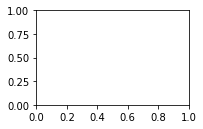

In [6]:
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()

# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)

# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [ ]:
phot[]

In [11]:
np.set_printoptions(threshold=np.inf)
mpdf

array([[7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611248e-05,
        7.23611248e-05, 7.23611248e-05, 7.23611248e-05, 7.23611249e-05,
        7.23611252e-05, 7.23611263e-05, 7.23611294e-05, 7.23611452e-05,
        7.23619754e-05, 7.23857006e-05, 7.35808933e-05, 7.82141255e-05,
        9.28303951e-05, 1.29582111e-04, 2.03265852e-04, 3.418146

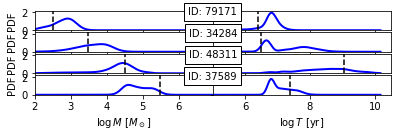

In [7]:
# Pick out some clusters to use as examples. We'll just pick ones
# where Chandar has estimated masses of 10^2.5, 3.5, 4.5, and 5.5
idx = np.zeros(4, dtype=int)
for i in range(4):
    idx[i] = np.argmin(np.abs(chfit_logm[valid]-2.5-i))

# For the example clusters, make plots of our computed posterior
# distributions of mass and age, with the SSP fits from Chandar
# overlaid
xmra = [2, 6.95]
xtra = [5, 10.5]
yra = [0, 2.2]
for i in range(len(idx)):

    # Plot masses
    axmass = plt.subplot(12,2,2*i+1)
    plt.plot(logm, mpdf[idx[i],:], 'b', lw=2)
    plt.plot(chfit_logm[valid][idx[i]]*np.ones(2), yra, 'k--')
    plt.xlim(xmra)
    plt.ylim(yra)
    plt.ylabel('PDF')
    if i == len(idx)-1:
        plt.xlabel('$\log\,M$ [$M_\odot$]')
    else:
        axmass.get_xaxis().set_ticklabels([])

    # Plot ages
    axage = plt.subplot(12,2,2*i+2)
    p1,=plt.plot(logt, tpdf[idx[i],:], 'b', lw=2)
    p3,=plt.plot(chfit_logt[valid][idx[i]]*np.ones(2), yra, 'k--')
    plt.xlim(xtra)
    plt.ylim(yra)
    axage.get_yaxis().set_ticklabels([])
    if i == len(idx)-1:
        plt.xlabel('$\log\,T$ [yr]')
    else:
        axage.get_xaxis().set_ticklabels([])

    # Add label
    plt.text(xtra[0], 0.8*yra[1], 'ID: {:d}'.
             format(int(cluster_id[valid][idx[i]])),
             horizontalalignment='center',
             bbox={'facecolor':'w'})

plt.subplots_adjust(hspace=0.1, wspace=0, bottom=0.08, top=0.97, right=0.95)
plt.savefig('cluster_slug_example_1.pdf')

In [ ]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])

# For each model, find the best match in the library
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=5)
dist = dist/np.sqrt(len(filters))

# Make a scatter plot of our median mass vs. Chandar's fit, coloring
# points by how close they are to a cluster_slug model
fig = plt.figure(2, figsize=(10,4))
ax = fig.add_axes([0.07, 0.14, 0.35, 0.79])
plt.scatter(chfit_logm[valid], mpercentiles[1,:], c=np.log10(dist[:,-1]), 
            vmin=-1.5, vmax=0)
plt.plot([2,7], [2,7], 'k--')   # overplot 1-1 line
plt.xlabel('$\log\,(M/M_\odot)$ (Chandar+)')
plt.ylabel('$\log\,(M/M_\odot)$ (cluster_slug)')
plt.xlim([2,7])
plt.ylim([2,7])

# Add errorbars showing inter-quartile range
err = np.abs(mpercentiles[1,:]-mpercentiles[::2,:])
plt.errorbar(chfit_logm[valid], mpercentiles[1,:], yerr=err, 
             fmt='none', ecolor='k', errorevery=20)

# Same procedure for ages
ax2 = fig.add_axes([0.51, 0.14, 0.35, 0.79])
plt.scatter(chfit_logt[valid], tpercentiles[1,:], c=np.log10(dist[:,-1]), 
            vmin=-1.5, vmax=0)
plt.plot([5,10.5], [5,10.5], 'k--')   # overplot 1-1 line
err = np.abs(tpercentiles[1,:]-tpercentiles[::2,:])
plt.errorbar(chfit_logt[valid], tpercentiles[1,:], yerr=err, 
             fmt='none', ecolor='k', errorevery=20)
plt.xlabel('$\log\,(T/\mathrm{yr})$ (Chandar+)')
plt.ylabel('$\log\,(T/\mathrm{yr})$ (cluster_slug)')
plt.xlim([5,10.5])
plt.ylim([5,10.5])

# Add colorbar
axcbar = fig.add_axes([0.88, 0.14, 0.02, 0.79])
plt.colorbar(cax=axcbar, label='Log photometric distance [mag]')

# Save
plt.savefig('cluster_slug_example_2.pdf')

# Print out some information
pd = np.percentile(dist[:,0], [90, 95])
print("Nearest neighbor photometric distances (mag):\n" +
      "90th percentile = {}, 95th percentile = {}".format(pd[0], pd[1]))
pd = np.percentile(dist[:,4], [90, 95])
print("5th nearest neighbor photometric distances (mag):\n" +
      "90th percentile = {}, 95th percentile = {}".format(pd[0], pd[1]))


In [ ]:
np.set_printoptions(threshold=np.inf)
mpdfsum